In [1]:
# Build the CNN+Transformer model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Model construction
embed_dim = 128  # Embedding size for each token
num_heads = 4    # Number of attention heads
ff_dim = 128     # Hidden layer size in feed-forward network

In [2]:
# Set the data path
data_path = 'C:/Users/USER/Desktop/프보기/preprocessed'

# Load data
def load_data(data_path):
    data = []
    labels = []
    
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path) and (folder.endswith('_walk_3') or folder.endswith('_down_3') or folder.endswith('_up_3')):
            # Read accelerometer and gyroscope data
            acc_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')
            
            if os.path.exists(acc_path) and os.path.exists(gyro_path):
                acc_data = pd.read_csv(acc_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                gyro_data = pd.read_csv(gyro_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                
                # Ensure both data arrays have the same number of rows
                min_length = min(len(acc_data), len(gyro_data))
                acc_data = acc_data[:min_length]
                gyro_data = gyro_data[:min_length]
                
                # Concatenate accelerometer and gyroscope data
                combined_data = np.hstack((acc_data, gyro_data))
                
                # Apply sliding window technique to generate more samples
                window_size = 100
                step_size = 50
                for start in range(0, len(combined_data) - window_size + 1, step_size):
                    window_data = combined_data[start:start + window_size]
                    data.append(window_data)
                    labels.append(folder.split('_')[0])
    
    return data, labels

# Prepare the data
data, labels = load_data(data_path)

# Pad sequences to the same length (if necessary)
max_length = max([len(d) for d in data])
data = [np.pad(d, ((0, max_length - len(d)), (0, 0)), 'constant') if len(d) < max_length else d for d in data]
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

In [3]:
model_cnn_transformer = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_length, data.shape[2])),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    TransformerBlock(embed_dim=128, num_heads=num_heads, ff_dim=ff_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model_cnn_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_transformer = model_cnn_transformer.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate the model
y_pred_cnn_transformer = model_cnn_transformer.predict(X_test)
y_pred_classes_cnn_transformer = np.argmax(y_pred_cnn_transformer, axis=1)


Epoch 1/50
82/82 [==============================] - 2s 10ms/step - loss: 2.5229 - accuracy: 0.1482 - val_loss: 2.2824 - val_accuracy: 0.1931
Epoch 2/50
82/82 [==============================] - 1s 6ms/step - loss: 1.8711 - accuracy: 0.3210 - val_loss: 1.7626 - val_accuracy: 0.3448
Epoch 3/50
82/82 [==============================] - 1s 7ms/step - loss: 1.3636 - accuracy: 0.4969 - val_loss: 1.1809 - val_accuracy: 0.5862
Epoch 4/50
82/82 [==============================] - 1s 8ms/step - loss: 1.0582 - accuracy: 0.6037 - val_loss: 1.1626 - val_accuracy: 0.5793
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 0.8054 - accuracy: 0.6920 - val_loss: 0.7456 - val_accuracy: 0.7241
Epoch 6/50
82/82 [==============================] - 1s 7ms/step - loss: 0.5799 - accuracy: 0.7865 - val_loss: 0.7156 - val_accuracy: 0.7586
Epoch 7/50
82/82 [==============================] - 1s 6ms/step - loss: 0.5775 - accuracy: 0.7688 - val_loss: 0.6865 - val_accuracy: 0.7586
Epoch 8/50
82/82 [=

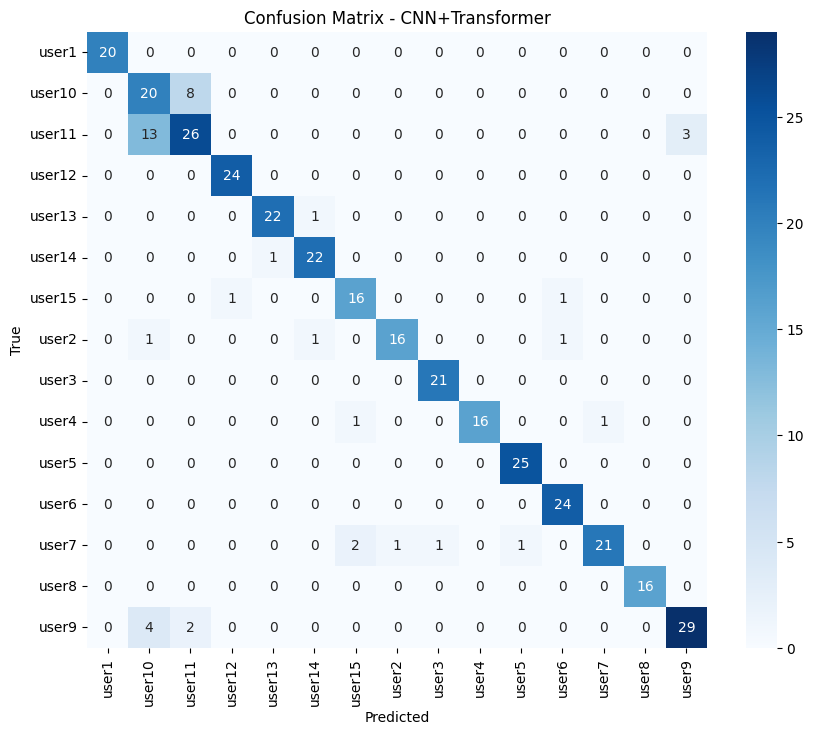

Classification Report - CNN+Transformer
              precision    recall  f1-score   support

       user1       1.00      1.00      1.00        20
      user10       0.53      0.71      0.61        28
      user11       0.72      0.62      0.67        42
      user12       0.96      1.00      0.98        24
      user13       0.96      0.96      0.96        23
      user14       0.92      0.96      0.94        23
      user15       0.84      0.89      0.86        18
       user2       0.94      0.84      0.89        19
       user3       0.95      1.00      0.98        21
       user4       1.00      0.89      0.94        18
       user5       0.96      1.00      0.98        25
       user6       0.92      1.00      0.96        24
       user7       0.95      0.81      0.88        26
       user8       1.00      1.00      1.00        16
       user9       0.91      0.83      0.87        35

    accuracy                           0.88       362
   macro avg       0.90      0.90      0

In [4]:
# Confusion matrix for CNN+Transformer with fixed class names
conf_matrix_cnn_transformer = confusion_matrix(y_test, y_pred_classes_cnn_transformer)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn_transformer, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN+Transformer')
plt.show()

# Classification report for CNN+Transformer
print("Classification Report - CNN+Transformer")
print(classification_report(y_test, y_pred_classes_cnn_transformer, target_names=label_encoder.classes_))

# Print model summary to see the number of parameters
model_cnn_transformer.summary()